In [11]:
!pip install anastruct

     |████████████████████████████████| 61kB 6.3MB/s 


In [19]:
!pip uninstall anastruct -y

Uninstalling anastruct-1.0.2:
  Successfully uninstalled anastruct-1.0.2


In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import GPy
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm
from functools import partial

# http://krasserm.github.io/2018/03/21/bayesian-optimization/

# Expected Improvement

[derivation](http://ash-aldujaili.github.io/blog/2018/02/01/ei/)

$$\text{EI}(x) = \mathbb{E}\max(f(x^*) - f(x^+), 0)$$

$$\text{EI}(x) = (\mu(x^*) - f(x^+)) \Phi(\frac{\mu(x^*) - f(x^+)}{\sigma(x^*)}) + \sigma(x^*) \phi(\frac{\mu(x^*) - f(x^+)}{\sigma(x^*)})$$

* $\Phi$ = CDF standard normal
* $\phi$ = PDF standard normal
* $x^*$ = proposed points
* $x^+$ = current best

Numerrically unstable if $\sigma \to 0$

$$\text{EI}(x) = (\mu(x^*) - f(x^+)) \Phi(Z) + \sigma \phi(Z)$$

$$Z = \begin{cases}
    \frac{\mu(x^*) - f(x^+)}{\sigma(x^*)},& \text{if } \sigma(x^*) > 0 \\
    0,              & \text{otherwise}
\end{cases}$$

Let $\mu(x^*) - f(x^+) := \delta$.

$$Z = \begin{cases}
    \frac{\delta}{\sigma(x^*)},& \text{if } \sigma(x^*) > 0 \\
    0,              & \text{otherwise}
\end{cases}$$

$$\text{EI}(x) = (\delta) \Phi(Z) + \sigma(x^*) \phi(Z)$$

Recommendation value for $\xi = 0.01$. 


In [2]:

def select_hyperparams_random(param_ranges):
    """
    Select hyperparameters at random.
    
    Parameters
    ----------
    param_ranges : dict
        Named parameter ranges.

        Example:
        
        {
            'foo': {
                'range': [1, 10],
                'type': 'float'
            }
            'bar': {
                'range': [10, 1000],
                'type': 'int'
            }
        }

    Returns
    -------
    selection : dict
        Randomly selected hyperparameters within given boundaries.
        
        Example:
        {'foo': 4.213, 'bar': 935}

    """
    selection = {}
    for k in param_ranges:
        val = np.random.choice(
            np.linspace(*param_ranges[k]['range'], num=100)
        )

        dtype = param_ranges[k]['type']
        if dtype is 'int':
            val = int(val)
        selection[k] = val
    return selection


def expected_improvement(f, y_current, x_proposed):
    """
    Return E(max(f_proposed - f_current), 0)

    Parameters
    ----------

    f : GP predict function
    y_current : float
        Current best evaluation f(x+)
    x_proposed : np.array
        Proposal parameters. Shape: (1, 1)

    Returns
    -------
    expected_improvement : float
        E(max(f_proposed - f_current), 0)
    """
    mu, var = f(x_proposed)
    std = var ** 0.5
    delta = mu - y_current

    # x / inf = 0
    std[std == 0] = np.inf
    z = delta / std
    unit_norm = stats.norm()
    return delta * unit_norm.cdf(z) + std * unit_norm.pdf(z)



In [3]:
param_ranges = {
    'foo': {
        'range': [1, 10],
        'type': 'float'
    },
    'bar': {
        'range': [10, 1000],
        'type': 'int'
    }
}

select_hyperparams_random(param_ranges)

{'foo': 1.9090909090909092, 'bar': 440}

In [4]:
class BayesOpt:
    def __init__(
        self, param_ranges, f, random_trials=5, optimization_trials=20, kernel=None
    ):
        """
        Parameters
        ----------

        param_ranges : dict
        f : function
            black box function to evaluate
        random_trials : int
            Number of random trials to run before optimization starts
        optimization_trials : int
            Number of optimization trials to run.
            Together with the random_trials this is the total budget
        kernel: GPy.kern.src.kern.Kern
            GPy kernel for the Gaussian Process.
            If None given, RBF kernel is used
        """
        self.param_ranges = param_ranges
        self.f = f
        self.random_trials = random_trials
        self.optimization_trials = optimization_trials
        self.n_trials = random_trials + optimization_trials
        self.x = np.zeros((self.n_trials, len(param_ranges)))
        self.y = np.zeros((self.n_trials, 1))

        if kernel is None:
            self.kernel = GPy.kern.RBF(
                input_dim=self.x.shape[1], variance=1, lengthscale=1
            )
        else:
            self.kernel = kernel
        self.gp = None
        self.bounds = np.array([pr["range"] for pr in param_ranges.values()])

    @property
    def best_params(self):
        """
        Select best parameters.

        Returns
        -------
        best_parameters : dict
        """
        return self._prepare_kwargs(self.x[self.y.argmax()])

    def fit(self):
        self._random_search()
        self._bayesian_search()

    def _random_search(self):
        """
        Run the random trials budget
        """
        print(f"Starting {self.random_trials} random trials...")
        for i in tqdm(range(self.random_trials)):
            hp = select_hyperparams_random(self.param_ranges)
            self.x[i] = np.array(list(hp.values()))
            self.y[i] = self.f(hp)

    def _bayesian_search(self):
        """
        Run the Bayesian Optimization budget
        """
        print(f"Starting {self.optimization_trials} optimization trials...")
        for i in tqdm(
            range(self.random_trials, self.random_trials + self.optimization_trials)
        ):
            self.x[i], self.y[i] = self._single_iter()

    def _single_iter(self, x=None):
        """
        Fit a GP and retrieve and evaluate a new
        parameter proposal.

        Returns
        -------
        out : tuple[np.array[flt], np.array[flt]]
            (x, f(x))

        """
        self._fit_gp()
        if x is None:
            x = self._new_proposal()
        y = self.f(self._prepare_kwargs(x))
        return x, y

    def _fit_gp(self, noise_var=0):
        """
        Fit a GP on the currently observed data points.

        Parameters
        ----------
        noise_var : flt
            GPY argmument noise_var
        """
        mask = self.x.sum(axis=1) != 0
        self.gp = GPy.models.GPRegression(
            self.x[mask],
            self.y[mask],
            normalizer=True,
            kernel=self.kernel,
            noise_var=noise_var,
        )
        self.gp.optimize()

    def _new_proposal(self, n=25):
        """
        Get a new parameter proposal by maximizing
        the acquisition function.

        Parameters
        ----------
        n : int
            Number of retries.
            Each new retry the optimization is
            started in another parameter location.
            This improves the chance of finding a global optimum.

        Returns
        -------
        proposal : dict
            Example:
           {'foo': 4.213, 'bar': 935}
        """

        def f(x):
            return -expected_improvement(
                f=self.gp.predict, y_current=self.y.max(), x_proposed=x[None, :]
            )

        x0 = np.random.uniform(
            low=self.bounds[:, 0], high=self.bounds[:, 1], size=(n, self.x.shape[1])
        )
        proposal = None
        best_ei = np.inf
        for x0_ in x0:
            res = optimize.minimize(f, x0_, bounds=self.bounds)
            if res.success and res.fun < best_ei:
                best_ei = res.fun
                proposal = res.x
            if np.isnan(res.fun):
                raise ValueError("NaN within bounds")
        return proposal

    def _prepare_kwargs(self, x):
        """
        Create a dictionary with named parameters
        and the proper python types.

        Parameters
        ----------
        x : np.array
            Example:
            [4.213, 935.03]

        Returns
        -------
        hyperparameters : dict

            Example:
            {'foo': 4.213, 'bar': 935}
        """
        # create hyper parameter dict
        hp = dict(zip(self.param_ranges.keys(), x))
        # cast values
        for k in self.param_ranges:
            if self.param_ranges[k]["type"] == "int":
                hp[k] = int(hp[k])
            elif self.param_ranges[k]["type"] == "float":
                hp[k] = float(hp[k])
            else:
                raise ValueError("Parameter type not known")
        return hp

# 1D

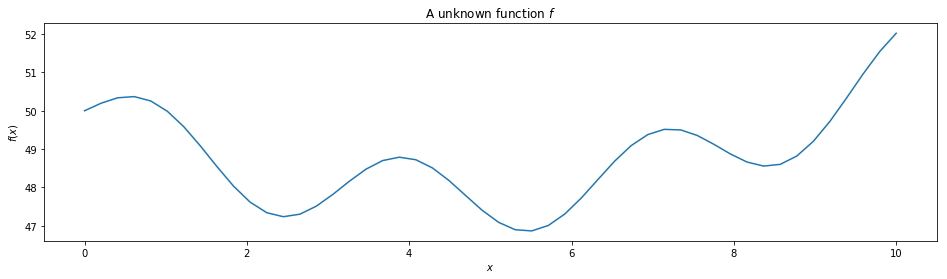

In [5]:
x = np.linspace(0, 10)

def func(x):
    return np.sin(2 * x) + (x / 3)**2 - x + 50

plt.figure(figsize=(16, 4))
plt.title('A unknown function $f$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(x, func(x))


In [6]:
def evaluate_params(hyperparams):
    return func(**hyperparams)

param_ranges = {
    'x': {
        'range': [0, 10],
        'type': 'float'
    }
}


100%|██████████| 2/2 [00:00<00:00, 3763.40it/s]

Starting 2 random trials...



 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


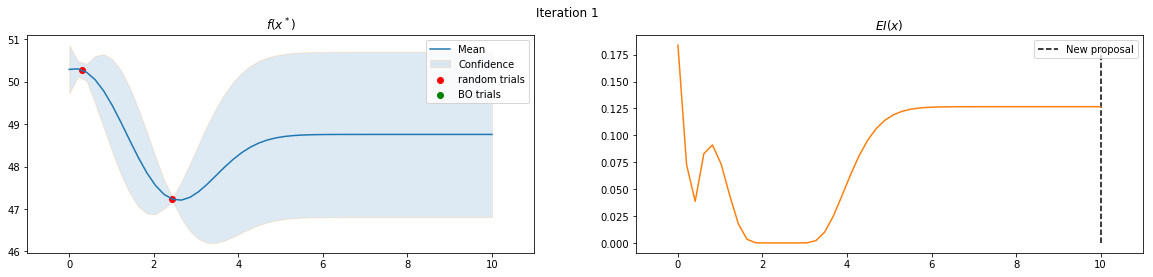

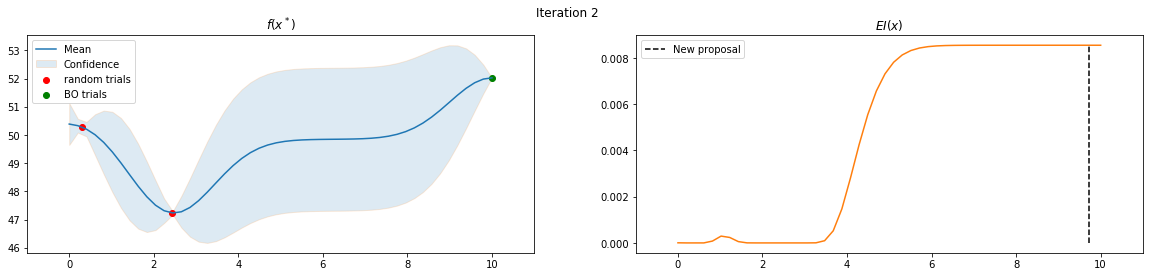

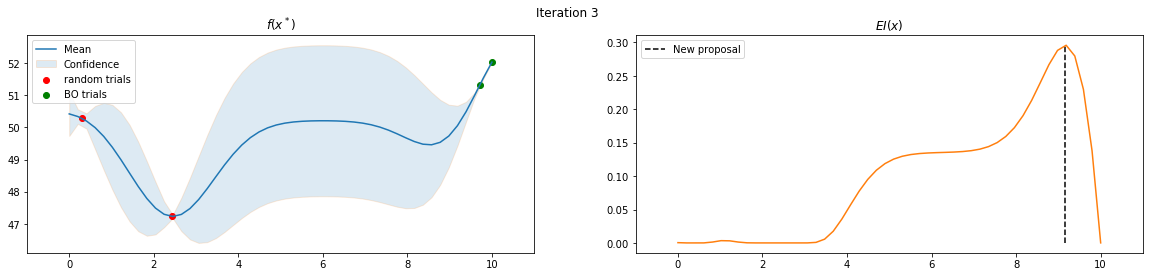

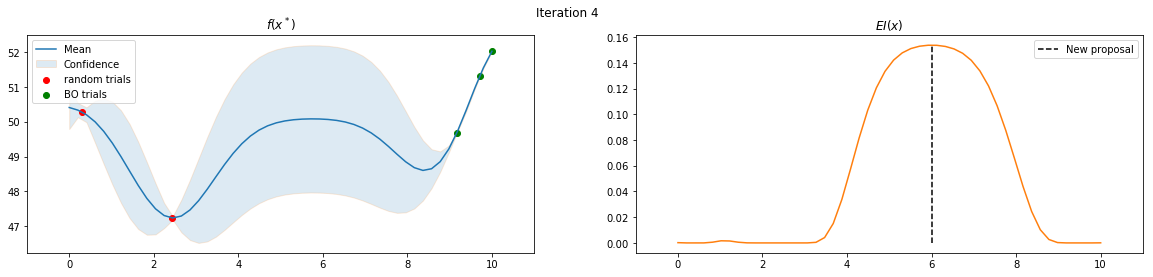

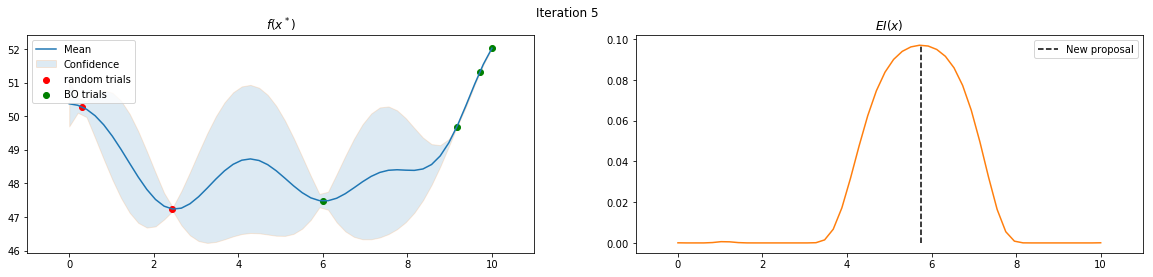

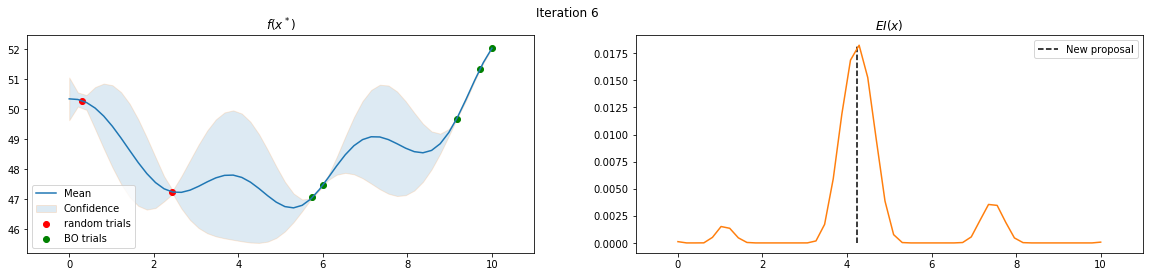

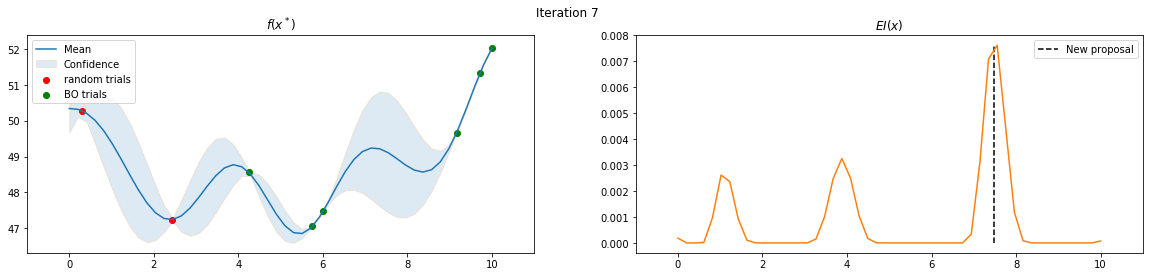

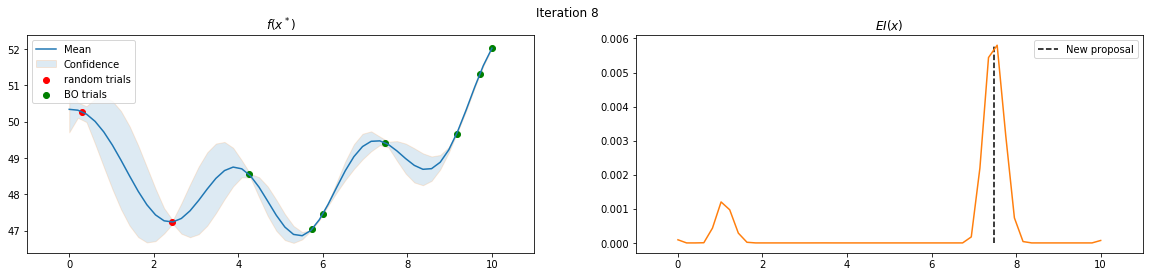

In [7]:
np.random.seed(3)
bo = BayesOpt(param_ranges, evaluate_params, random_trials=2)
bo._random_search()
bo._fit_gp()
new_proposal = bo._new_proposal()
x_, y_ = bo._single_iter(new_proposal)

for i in range(2, 10):
    new_proposal = bo._new_proposal()
    ei = expected_improvement(
        f=bo.gp.predict, y_current=bo.y.max(), x_proposed=x[:, None]
    )
    x_, y_ = bo._single_iter(new_proposal)
    bo.x[i], bo.y[i] = x_, y_

    quants = bo.gp.predict_quantiles(x[:, None], quantiles=(10, 90))
    mu, var = bo.gp.predict(x[:, None])

    plt.figure(figsize=(20, 4))
    plt.suptitle(f"Iteration {i - 1}")
    plt.subplot(1, 2, 1)
    plt.title("$f(x^*)$")
    plt.plot(x, mu, color="C0", label="Mean")
    plt.fill_between(
        x,
        quants[0].flatten(),
        quants[1].flatten(),
        alpha=0.15,
        edgecolor="C1",
        label="Confidence",
    )
    plt.scatter(
        bo.x[: bo.random_trials],
        bo.y[: bo.random_trials],
        color="r",
        label="random trials",
    )
    plt.xlim(x.min() - 1, x.max() + 1)
    mask = bo.x.sum(axis=1) != 0
    plt.scatter(
        bo.x[mask][bo.random_trials : -1],
        bo.y[mask][bo.random_trials : -1],
        color="g",
        label="BO trials",
    )

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("$EI(x)$")
    plt.plot(x, ei, color="C1")
    plt.vlines(new_proposal, 0, ei.max(), linestyle="--", label="New proposal")
    plt.xlim(x.min() - 1, x.max() + 1)
    plt.legend()


 /opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:divide by zero encountered in true_divide
 /opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:invalid value encountered in true_divide
 /opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:invalid value encountered in less
 /opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning:invalid value encountered in greater_equal
 /opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning:invalid value encountered in greater_equal
 /opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning:invalid value encountered in less_equal


Text(0, 0.5, '$\\sigma(x^*)$')

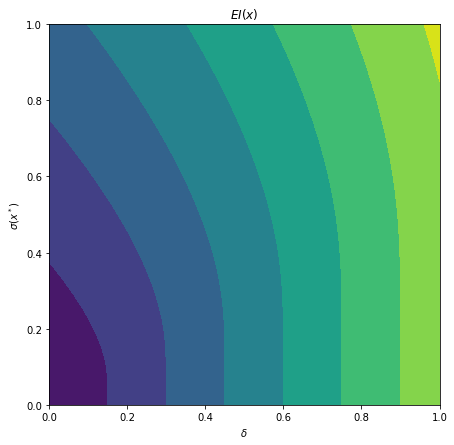

In [8]:
delta = np.linspace(0, 1)
sigma = np.linspace(0, 1)[::-1]
# get a square grid w/ the delta and sigma inputs
dd, ss = np.meshgrid(delta, sigma)

# this is just the EI function
z = dd / ss
unit_norm = stats.norm()
ei = dd * unit_norm.cdf(z) + ss * unit_norm.pdf(z)
ei[np.isnan(ei)] = 0

plt.figure(figsize=(7, 7))
plt.title('$EI(x)$')
plt.contourf(delta, sigma, ei)
plt.xlabel('$\delta$')
plt.ylabel('$\sigma(x^*)$')

In [ ]:
from water_accumulation import determine_max_water_cubic

In [15]:
maximum_factor = 1.3

param_ranges = {
    'mp_span_1': {
        'range': [70, int(70 * maximum_factor)],
        'type': 'float'
    },
    'mp_span_2': {
        'range': [240, int(240 * maximum_factor)],
        'type': 'float'
    },
    'mp_span_3': {
        'range': [25, int(25 * maximum_factor)],
        'type': 'float'
    },
    'k1': {
        'range': [2000, int(2000 * maximum_factor)],
        'type': 'float'
    },
    'k2': {
        'range': [3000, int(3000 * maximum_factor)],
        'type': 'float'
    }
}

In [ ]:
bo = BayesOpt(param_ranges, 
              determine_max_water_cubic, 
              random_trials=5, 
              optimization_trials=20, 
              kernel=GPy.kern.Matern52(input_dim=3) + GPy.kern.Matern32(input_dim=3))
bo.fit()

## With real data

In [63]:
# decision tree
param_ranges = {
    'min_samples_split': {
        'range': [2, 10],
        'type': 'int'
    },
    'min_samples_leaf': {
        'range': [1, 10],
        'type': 'int'
    },
    'max_depth': {
        'range': [3, 1000],
        'type': 'int'
    }
}


def evaluate_params(hyperparams):
    m = DecisionTreeClassifier(**hyperparams)
    m.fit(x_train, y_train)
    return m.score(x_test, y_test)

In [98]:
datasets.load_diabetes()

<module 'sklearn.datasets.california_housing' from '/opt/miniconda3/lib/python3.7/site-packages/sklearn/datasets/california_housing.py'>

In [93]:
bo = BayesOpt(param_ranges, 
              evaluate_params, 
              random_trials=10, 
              optimization_trials=20, 
              kernel=GPy.kern.Matern52(input_dim=3) + GPy.kern.Matern32(input_dim=3) + GPy.kern.a)
bo.fit()

 20%|██        | 2/10 [00:00<00:00, 18.64it/s]

Starting 10 random trials...


  0%|          | 0/20 [00:00<?, ?it/s] /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Starting 20 optimization trials...


  5%|▌         | 1/20 [00:00<00:05,  3.55it/s] /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
 /opt/miniconda3/lib/python3.7/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:454: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /opt/miniconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:457: RuntimeWarning:invalid value encountered in multiply
 /opt/miniconda3/lib/python3.7/site-packages/paramz/t

In [94]:
bo.y.max()

0.8276849642004773

In [95]:
bo.y.max()

0.8276849642004773